## JPL Demo Notebook
This notebook demonstrates the functionality of JPL. We show how to load the model and perform detection on a single example image. We also show some example images from minidepth.

### Basic Setup

Import packages, set device and define utility functions

In [1]:
import cv2
import flow_vis
from matplotlib import pyplot as plt
import numpy as np
import torch
from gluefactory.models import get_model

In [2]:
# We want larger figures
plt.rcParams["figure.figsize"] = (7,7)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")
device = "cpu"

Using device: mps


In [4]:
def get_flow_vis(df, ang, line_neighborhood=5):
    """Visualize flow of angle field"""
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions.
    Used when loading single Images, not from a glue-factory dataset"""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

def load_image_from_path(path: str, resize=(800,800), plot_image=True):
    img = cv2.resize(cv2.imread(path), resize)
    if plot_image:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
    img_torch = numpy_image_to_torch(img).to(device)
    img_torch = img_torch.unsqueeze(0)
    return img_torch

Import and visualize demo picture

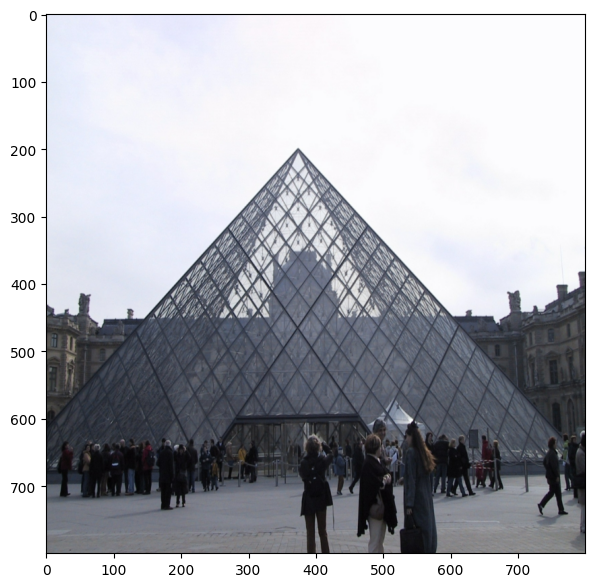

In [5]:
size = (800,800)
image_path = f"demo_louvre.jpg"
torch_image = load_image_from_path(image_path, resize=size, plot_image=True)

### Load the Model

Here we give no configuration. The weights are downloaded automatically and should agree with the default conf. Also, the line_detection is activated by default.

Currently the loaded model is oxparis-800-focal. The line detection is heuristic filtering based on the line-distance field

In [6]:
# The following config is an example that can be used to for ex. activate timing or deactivate line-detection. or having different checkpoint with different architecture (here oxparis_scannet_focal_800 where the number of channels is 64 instead of 32)
jpl_conf = {
    "max_num_keypoints": 1024,  # setting for training, for eval: -1
    "timeit": True,  # model collects timing statistics internally during forward passes
    "line_detection": {
        "do": False
    },
    "line_df_decoder_channels": 64,
    "checkpoint": "https://filedn.com/lt6zb4ORSwapNyVniJf1Pqh/JPL/checkpoint_oxparis_scannet_800_focal.tar"
}

# load the default model
jpldd_model = get_model("joint_point_line_extractor")(jpl_conf).to(device)
jpldd_model.eval()

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [7]:
# run fw pass with one image
with torch.no_grad():
    output_jpldd = jpldd_model({"image": torch_image})

print("-- Output Keys --")
for i, key in enumerate(output_jpldd.keys()):
    print(f"{i}: {key}, shape: {output_jpldd[key][0].shape}")

-- Output Keys --
0: keypoint_and_junction_score_map, shape: torch.Size([800, 800])
1: line_distancefield, shape: torch.Size([800, 800])
2: keypoints, shape: torch.Size([1024, 2])
3: keypoint_scores, shape: torch.Size([1024])
4: descriptors, shape: torch.Size([1024, 128])


### Visualize results

In [8]:
def visualize_jpl_output(image, output_dictionary: dict):
    num_subplots = 3
    has_line_af = "line_anglefield" in list(output_dictionary.keys())
    has_lines = "lines" in list(output_dictionary.keys())
    if has_line_af:
        num_subplots += 1
    if has_lines:
        num_subplots += 1
    fig, ax = plt.subplots(1, num_subplots, figsize=(16, 4))
    ax[0].axis('off')
    ax[0].set_title('KeyPoint & Junction Heatmap')
    ax[0].imshow(output_jpldd["keypoint_and_junction_score_map"][0])

    ax[1].axis('off')
    ax[1].set_title('Distance Field')
    ax[1].imshow(output_jpldd["line_distancefield"][0])

    keypoints = output_dictionary["keypoints"][0]
    ax[2].axis('off')
    ax[2].set_title('Detected keypoints')
    ax[2].imshow(image.cpu().squeeze(0).permute(1,2,0))
    ax[2].scatter(keypoints[:, 0], keypoints[:, 1], marker="o", color="red", s=3)
    if has_line_af:
        ax[3].axis('off')
        ax[3].set_title('Angle Field')
        ax[3].imshow(get_flow_vis(output_jpldd["line_distancefield"][0], output_jpldd["line_anglefield"][0]))
    if has_lines:
        lines = output_dictionary["lines"][0]
        ax[4].axis('off')
        ax[4].set_title('Detected Lines')
        print("Num JPLDD lines", lines.shape[0])
        for i in range(lines.shape[0]):
            line = lines[i]
            x1,y1 = line[0]
            x2,y2 = line[1]
            ax[0].plot([x1,x2],[y1,y2],'y-')
    plt.show()

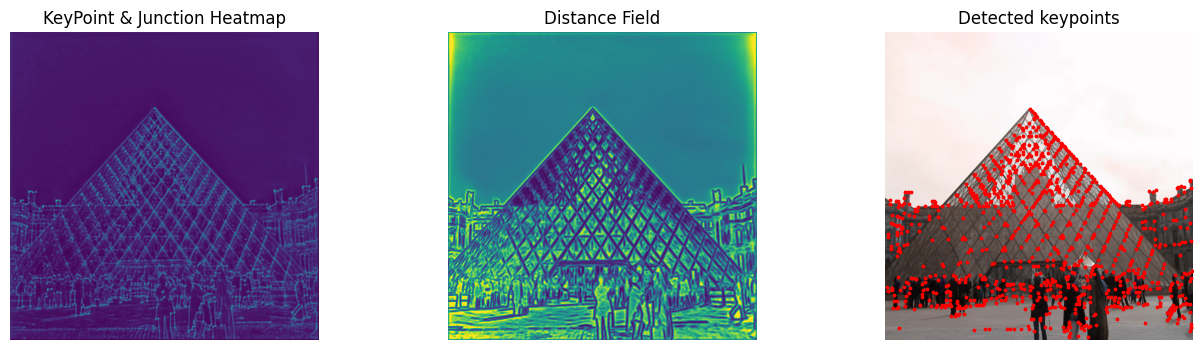

In [9]:
visualize_jpl_output(torch_image, output_jpldd)

## Visualize Results on Minidepth

In [10]:
def visualize_img_with_gt(dset, num=5, offset=0, lim_kpoints=-1):
    idxs = list(range(offset, offset+num, 1))
    _, ax = plt.subplots(len(idxs), 4, figsize=(20, num*4))
    for i in idxs:
        elem = dset[i]

        af = elem["deeplsd_angle_field"]
        df = elem["deeplsd_distance_field"]
        hmap = elem["superpoint_heatmap"]
        orig_pt = elem["gt_keypoints"]

        ax[i, 0].axis('off')
        ax[i, 0].set_title(f'Heatmap ({hmap.shape})')
        ax[i, 0].imshow(hmap)

        ax[i, 1].axis('off')
        ax[i, 1].set_title('Distance Field')
        ax[i, 1].imshow(df)

        ax[i, 2].axis('off')
        ax[i, 2].set_title('Angle Field')
        ax[i, 2].imshow(get_flow_vis(df, af))

        ax[i, 3].axis('off')
        ax[i, 3].set_title('Original')
        ax[i, 3].imshow(elem["image"].permute(1,2,0))
        ax[i, 3].scatter(orig_pt[:lim_kpoints, 0], orig_pt[:lim_kpoints, 1], marker="o", color="red", s=3)
    plt.show()

def compute_and_visualize(img_data_with_gt, model, device, visualize=False):
    img_torch = img_data_with_gt["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = model({"image": img_torch})
    jpldd_kpjhm = output_model['keypoint_and_junction_score_map'][0].cpu()
    jpldd_af = output_model['line_anglefield'][0].cpu()
    jpldd_df = output_model['line_distancefield'][0].cpu()
    jpldd_kp = output_model['keypoints'][0].cpu()

    af_gt = img_data_with_gt["deeplsd_angle_field"].cpu()
    df_gt = img_data_with_gt["deeplsd_distance_field"].cpu()
    hmap_gt = img_data_with_gt["superpoint_heatmap"].cpu()
    orig_pt_gt = img_data_with_gt["gt_keypoints"].cpu()
    print(f"Num GT-KP: {orig_pt_gt.shape[0]}")

    if visualize:
        _, ax = plt.subplots(2, 4, figsize=(20, 8))
        ax[0, 0].axis('off')
        ax[0, 0].set_title('GT-Heatmap')
        ax[0, 0].imshow(hmap_gt)

        ax[0, 1].axis('off')
        ax[0, 1].set_title('GT-Distance Field')
        ax[0, 1].imshow(df_gt)

        ax[0, 2].axis('off')
        ax[0, 2].set_title('GT-Angle Field')
        ax[0, 2].imshow(get_flow_vis(df_gt, af_gt))

        ax[0, 3].axis('off')
        ax[0, 3].set_title('GT-Keypoints')
        ax[0, 3].imshow(img_data_with_gt["image"].permute(1,2,0))
        ax[0, 3].scatter(orig_pt_gt[:, 0], orig_pt_gt[:, 1], marker="o", color="red", s=3)

        ax[1, 0].axis('off')
        ax[1, 0].set_title('KP&J Heatmap')
        ax[1, 0].imshow(jpldd_kpjhm)

        ax[1, 1].axis('off')
        ax[1, 1].set_title('Distance Field')
        ax[1, 1].imshow(jpldd_df)

        ax[1, 2].axis('off')
        ax[1, 2].set_title('Angle Field')
        ax[1, 2].imshow(get_flow_vis(jpldd_df, jpldd_af))

        ax[1, 3].axis('off')
        ax[1, 3].set_title('Detected kp')
        ax[1, 3].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
        ax[1, 3].scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], marker="o", color="red", s=3)
        plt.show()
    return output_model

from gluefactory.datasets import get_dataset

In [11]:
# get dataset (bx default feature-loading is deactivated, so activated it here to show gt)
dset_conf = {
            "reshape": 800,
            "square_pad": False,
            "load_features": {
                "do": True,
            },
        }
#oxparis datset name: oxford_paris_mini_1view_jpldd
loaded_ds = get_dataset("oxford_paris_mini_1view_jpldd")(dset_conf)
ds = loaded_ds.get_dataset(split="train")

# load one test element
elem = ds[0]
print(elem['name'])
print(f"Img-Shape: {elem['image'].shape}")
print(f"Keys: {elem.keys()}")

/Users/rkre/miniconda3/envs/jpl_gluefactory/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
[03/20/2025 13:49:06 gluefactory.datasets.base_dataset INFO] Creating dataset OxfordParisMiniOneViewJPLDD
[03/20/2025 13:49:06 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] DATASET OVERALL(NO-SPLIT) IMAGES: 12000
[03/20/2025 13:49:06 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES: 11500
[03/20/2025 13:49:06 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] KNOWN BATCHSIZE FOR MY SPLIT(train) is 2
[03/20/2025 13:49:06 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES WITH GT: 11500


/Users/rkre/PycharmProjects/glue-factory/data/revisitop1m_POLD2/jpg/078/078f89a2bad8c9292f791634c76c9db/base_image.jpg
Img-Shape: torch.Size([3, 600, 800])
Keys: dict_keys(['name', 'scales', 'image_size', 'transform', 'original_image_size', 'image', 'deeplsd_distance_field', 'deeplsd_angle_field', 'superpoint_heatmap'])


## Check Timings

To get a better insight into how long each part of the pipeline takes during forward pass, we implemented the option to collect inner timings. In order to be able to get inner timings, you need to set `timeit: True` in the configuration, as it is deactivated by default.

Why?: collecting inner timings involves synchronizing CUDA operations before each measurement. This negatively affects the overall throughput slightly.

If you chose the alternative jpl_conf in the 1st cell, timeit is activated and you can continue. Otherwise, the following commands will not work.

In [12]:
# get inner timings as dictionary. Use reset option to delete collected data up to date.
timings = jpldd_model.get_current_timings(reset=False)
for net_part, time in timings.items():
    print(f"{net_part}: {time}")

total-makespan: 1.142643928527832
encoder: 0.1726388931274414
keypoint-and-junction-heatmap: 0.03250384330749512
line-df: 0.41169309616088867
descriptor-branch: 0.08578610420227051
keypoint-detection: 0.3459608554840088
